In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Part I: Advertising is working, right ?

<img src='omer.png'/>

### Let's look at this dataset from Criteo and prove advertising is working !

In [25]:
df = pd.read_csv('criteo-small-causal-inference-problem.csv.gz', compression='gzip', nrows=10**6)

In [3]:
df.head()

,context,vertical,temperature,nb_product_views,nb_displays,nb_clicks,nb_sales
0,1,3,23,1,1,0,2
1,6,2,21,92,36,0,13
2,3,1,20,5,10,2,7
3,2,3,34,10,4,0,1
4,1,3,30,1,1,0,1


1. Examine the dataset and propose a precise definition of "advertising is working"
1. Plot nb_sales as a fonction of nb_displays. What does it say ?
1. Plot nb_sales as a function of other variables (vertical, context, temperature). What does it say ?
1. Is it enough to prove advertising is working ?

## Part II: Are we really sure ?

<img src='marge2.jpeg'/>

1. Learn a linear regression `nb_sales ~ nb_displays` and note the coefficient of the model
1. Learn a linear regression `nb_sales ~ nb_displays, context, ...` and note the coefficients of the model
1. Is there a difference in coefficients ? Can you imagine why ?
1. What is the name of this phenomenon in causal literature ?
1. Are we still confident about our "advertising is working" hypothesis ?

## Part III: Let's look deeper, because at least in some cases I believe it should work

<img src='lisa.png' />

1. What hypothesis can we make about the causal relation of sales and displays ? Write the different possibilites based on the observed dependence
1. Let's assume there are no unobserved confounders. Redo the regression of previous part but for each `context` separately. What do you find and what does it say wrt the "advertising is working" hypothesis ?
1. Point limitations 

## Part IV: Causal Graph Discovery (Optional)

Thanks to Marge we have now a conditional independence test (see code below). 

<img src='marge.png' />

To complete our understanding we want now to uncover the specific causal relations among our variables.

1. what can we say about `temperature - nb_sales` ?
1. what can we say about `nb_clicks - nb_sales` ?
1. Let's look at (̀`context - nb_displays - nb_clicks`). Write up the different independence tests we need to uncover the causal graph between the 3 variables. Then perform those tests using the provided code to infer the causal structure.
1. Let's look at (̀`context - nb_displays - vertical - nb_sales`). We consider the following hypothesis for the causal graph `context -> (nb_displays, vertical) -> nb_sales`. Write up the different independence tests we need to verify if this structure is faithfully describing our data. What do you conclude ?

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

def modelbased_conditionnal_independence_test(
    dff,
    x_cols, y_col, z_cols, 
    model=LinearRegression(), #RandomForestRegressor(n_jobs=-1, n_estimators=30), 
    n_splits=100,
    loss=mean_squared_error,
):
    """
    Perform a conditional, model-based independence test of the form "is X independent of Y (given Z)".
    
    Internally, estimate the goodness of fit of a model predicting P(Y|Z) and compare it to the same
    model predicting P(Y|Z,X). 
    
    H0 is the hypothesis that X and Y are independent (given Z); i.e. all information linking X to Y is 
    flowing through Z so both models should perform similarly.

    H1 is the hypothesis that X is NOT independent of Y (given Z); i.e. X is bringing additional information 
    so the model with X as added feature should perform better.
    
    A low p-value (e.g. <.05) indicates that you cannot reject H1; i.e. X and Y are dependent.
    
    Returns a tuple:
    (
      - actual statistic (error of model using X as feature)
      - statistic distribution under H0 (error distribution of model NOT using X as feature)
      - corresponding p-value (proba to observe a loss at least as low as the actual loss under H0)
    )
    """
    h0_error_hist = []
    Z = dff[z_cols].values if z_cols is not None and len(z_cols) else np.ones(len(dff)).reshape(-1, 1)
    for _ in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(
            Z, # without X
            dff[y_col].values.ravel(), 
            test_size=0.2, random_state=_+1000
        )
        model.fit(X_train, y_train)
        h0_error_hist += [loss(y_test, model.predict(X_test))]
    h0_error_hist = sorted(h0_error_hist)

    X_train, X_test, y_train, y_test = train_test_split(
        np.hstack([dff[x_cols].values,Z]), # with added X
        dff[y_col].values.ravel(), 
        test_size=0.33, random_state=42
    )
    model.fit(X_train, y_train)
    actual_error = loss(y_test, model.predict(X_test))    
        
    fitted_h0_dist = norm(*norm.fit(h0_error_hist))
    pval = fitted_h0_dist.cdf(actual_error)
    
    return actual_error, h0_error_hist, pval

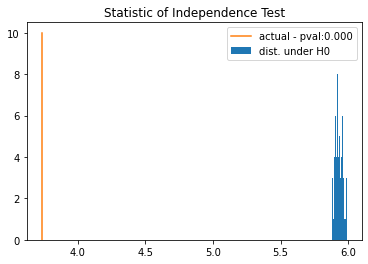

In [145]:
h1_err, h0_err_hist, pval = modelbased_conditionnal_independence_test(
    df,
    ['nb_displays'], # X
    ['nb_sales'], # Y
    None, # Z
)
plt.hist(h0_err_hist, bins=30, label='dist. under H0')
plt.plot((h1_err,h1_err),(0,10), label='actual - pval:%.3f' % pval)
plt.title('Statistic of Independence Test')
plt.legend()

## Conclusion

1. Write a conclusion that summarizes what you have learned
1. Discuss limitations of the approach, esp. wrt the independence test that is implemented. E.g. is it sufficient or necessary etc